In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(caret)
library(stringr)
install.packages("e1071", dependencies=TRUE, type='source')
library(e1071)
install.packages("GGally")
library(GGally)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘testthat’

The following object is masked from ‘package:dplyr’:

    matches

The following object is masked from ‘package:purrr’:

    is_null

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

also installing the dependencies ‘cluster’, ‘mlbench’, ‘SparseM’, ‘slam’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘progress’, ‘reshape’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



# “Who’s that Pokémon?”: Predicting Pokémon Types and Legendary status from their Generation and various Attributes using k-nn classification. 

## Introduction

On February 27 2019, the 23rd anniversary of the Pokémon franchise, Nintendo announced its latest Pokémon games, which will introduce the eighth generation of Pokémon. What unique Pokémon might we expect in this new game? The goal of this project is to train a k-nearest neighbours classification model that can predict a given Pokémon’s Type(s) as well as its Legendary status given its Generation number and Stats (a measure of a Pokémon’s capabilities). To train this model, we will use the Pokémon Stats Data Set, which contains the Names, Types, Generation, Stats, and Legendary-status of 800 Pokémon from six generations.

In [2]:
pokemon <- read_csv("https://raw.githubusercontent.com/UBC-DSCI/datasets/master/pokemon/Pokemon.csv")
head(pokemon)

Parsed with column specification:
cols(
  `#` = col_integer(),
  Name = col_character(),
  `Type 1` = col_character(),
  `Type 2` = col_character(),
  Total = col_integer(),
  HP = col_integer(),
  Attack = col_integer(),
  Defense = col_integer(),
  `Sp. Atk` = col_integer(),
  `Sp. Def` = col_integer(),
  Speed = col_integer(),
  Generation = col_integer(),
  Legendary = col_character()
)


#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NA,309,39,52,43,60,50,65,1,False
5,Charmeleon,Fire,NA,405,58,64,58,80,65,80,1,False


## Data Wrangling

Looking at the data as it is, it needs to be wrangled and cleaned to get it to a format necessary for classification. This process will involve, renaming the column names, removing unnecessary columns, adding new columns, and scaling the data.

In [3]:
#renaming the column headings to remove spaces between Type 1 and Type 2 and make the rest more understandable.
cleaning_data <- names(pokemon) <- c("Number","Name","Type_1", "Type_2", "Total", "Hit_Points", "Attack", "Defense", 
                                     "Special_Attack","Special_Defense", "Speed", "Generation", "Legendary")
head(cleaning_data)

[1] "Number"     "Name"       "Type_1"     "Type_2"     "Total"     
[6] "Hit_Points"

In [4]:
# removing the unnecessary columns
cleaned_pokemon <- pokemon %>% 
    select(-Number, -Name)
head(cleaned_pokemon)

Type_1,Type_2,Total,Hit_Points,Attack,Defense,Special_Attack,Special_Defense,Speed,Generation,Legendary
Grass,Poison,318,45,49,49,65,65,45,1,False
Grass,Poison,405,60,62,63,80,80,60,1,False
Grass,Poison,525,80,82,83,100,100,80,1,False
Grass,Poison,625,80,100,123,122,120,80,1,False
Fire,NA,309,39,52,43,60,50,65,1,False
Fire,NA,405,58,64,58,80,65,80,1,False


Below we will be creating new columns namely the Type_summary column and the Gen_1, Gen_2... columns.
The Type_summary column is required because it will be used to separate the data into pokemon with one or two types for further classification. The Generation column is split into six separate ones because,it is a categorical variable and would not have been evenly spaced.

In [5]:
#creating new columns 
cleaned_pokemon2 <- cleaned_pokemon %>% 
    mutate(Type_sum =(Type_1 == Type_2),
    Gen_1 = as.numeric(Generation == 1),
    Gen_2 = as.numeric(Generation == 2),
    Gen_3 = as.numeric(Generation == 3),
    Gen_4 = as.numeric(Generation == 4),
    Gen_5 = as.numeric(Generation == 5),
    Gen_6 = as.numeric(Generation == 6),
    Type_summary = if_else(is.na(`Type_2`), "Mono", "Dual"))
                                        
head(n = 10, cleaned_pokemon2)

Type_1,Type_2,Total,Hit_Points,Attack,Defense,Special_Attack,Special_Defense,Speed,Generation,Legendary,Type_sum,Gen_1,Gen_2,Gen_3,Gen_4,Gen_5,Gen_6,Type_summary
Grass,Poison,318,45,49,49,65,65,45,1,False,FALSE,1,0,0,0,0,0,Dual
Grass,Poison,405,60,62,63,80,80,60,1,False,FALSE,1,0,0,0,0,0,Dual
Grass,Poison,525,80,82,83,100,100,80,1,False,FALSE,1,0,0,0,0,0,Dual
Grass,Poison,625,80,100,123,122,120,80,1,False,FALSE,1,0,0,0,0,0,Dual
Fire,NA,309,39,52,43,60,50,65,1,False,NA,1,0,0,0,0,0,Mono
Fire,NA,405,58,64,58,80,65,80,1,False,NA,1,0,0,0,0,0,Mono
Fire,Flying,534,78,84,78,109,85,100,1,False,FALSE,1,0,0,0,0,0,Dual
Fire,Dragon,634,78,130,111,130,85,100,1,False,FALSE,1,0,0,0,0,0,Dual
Fire,Flying,634,78,104,78,159,115,100,1,False,FALSE,1,0,0,0,0,0,Dual
Water,NA,314,44,48,65,50,64,43,1,False,NA,1,0,0,0,0,0,Mono


In [6]:
#scaling relevant column data to normalize the features because different magnitudes in the attributes would
#bias the predictions. 
#Also removing unneccessary columns.
scaled_pokemon <- cleaned_pokemon2 %>%
    mutate(scaled_Total = scale(Total,center = FALSE), 
    scaled_Hit_Points = scale(Hit_Points, center = FALSE), 
    scaled_Attack = scale(Attack, center = FALSE),
    scaled_Defense = scale(Defense, center = FALSE),
    scaled_Special_Attack = scale(Special_Attack, center = FALSE),
    scaled_Special_Defense = scale(Special_Defense, center = FALSE),
    scaled_Speed = scale(Speed, center = FALSE),
    scaled_Gen_1 = scale(Gen_1, center = FALSE),
    scaled_Gen_2 = scale(Gen_2, center = FALSE),
    scaled_Gen_3 = scale(Gen_3, center = FALSE),
    scaled_Gen_4 = scale(Gen_4, center = FALSE),
    scaled_Gen_5 = scale(Gen_5, center = FALSE),
    scaled_Gen_6 = scale(Gen_6, center = FALSE)) %>%
    select(-Type_sum, -Generation,-Total, -Hit_Points, -Attack, -Defense, -Special_Attack, 
           -Special_Defense, -Speed, -Gen_1, -Gen_2, -Gen_3, -Gen_4, -Gen_5, -Gen_6)
head(scaled_pokemon)

Type_1,Type_2,Legendary,Type_summary,scaled_Total,scaled_Hit_Points,scaled_Attack,scaled_Defense,scaled_Special_Attack,scaled_Special_Defense,scaled_Speed,scaled_Gen_1,scaled_Gen_2,scaled_Gen_3,scaled_Gen_4,scaled_Gen_5,scaled_Gen_6
Grass,Poison,False,Dual,0.7041635,0.6092888,0.5734039,0.6109768,0.8137637,0.8426019,0.6061101,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,0.8968120,0.8123851,0.7255314,0.7855417,1.0015554,1.0370485,0.8081468,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,1.1625341,1.0831801,0.9595738,1.0349200,1.2519442,1.2963107,1.0775290,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,1.3839691,1.0831801,1.1702120,1.5336766,1.5273719,1.5555728,1.0775290,2.193913,0,0,0,0,0
Fire,NA,False,Mono,0.6842343,0.5280503,0.6085102,0.5361634,0.7511665,0.6481553,0.8754923,2.193913,0,0,0,0,0
Fire,NA,False,Mono,0.8968120,0.7853056,0.7489357,0.7231971,1.0015554,0.8426019,1.0775290,2.193913,0,0,0,0,0


## Exploratory Data Visualisations


In [36]:
install.packages("gridExtra")
library(gridExtra)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



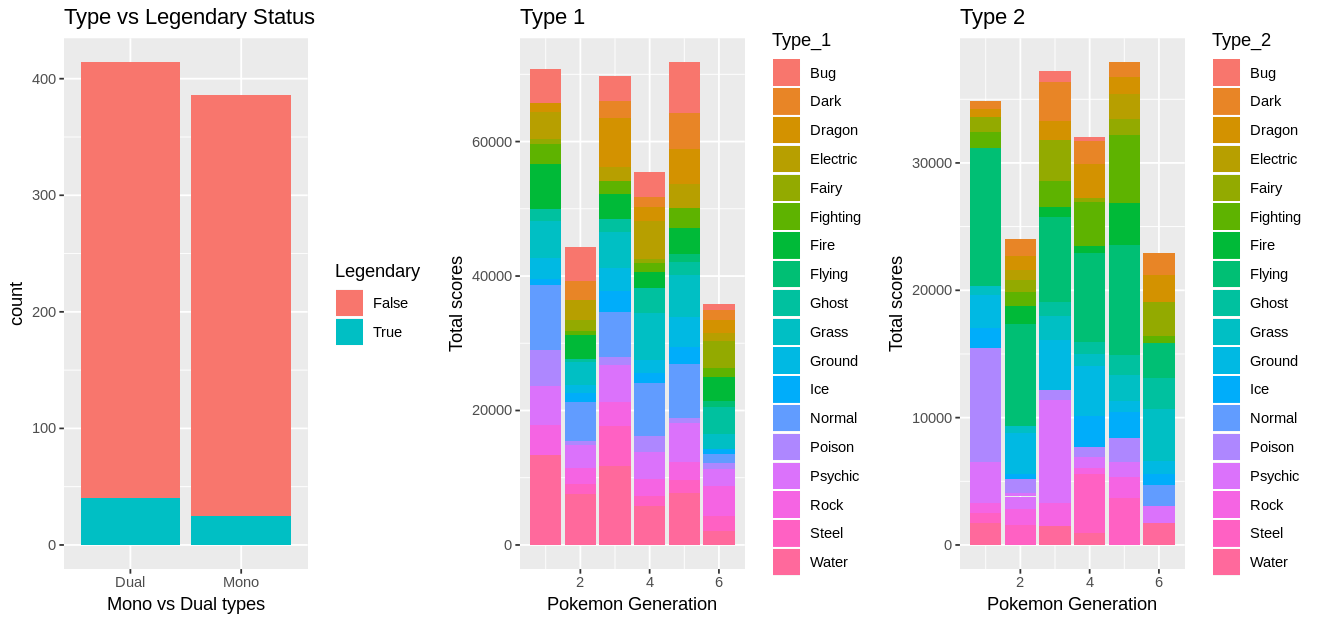

In [63]:
options(repr.plot.width= 11, repr.plot.height= 5.2)
viz1 <- scaled_pokemon %>%
        ggplot(aes(x= Type_summary, fill = Legendary))+
        geom_bar()+
        labs(x= "Mono vs Dual types") +
        ggtitle("Type vs Legendary Status")

viz2 <- cleaned_pokemon %>%
        ggplot(aes(x= Generation, y= Total, fill = Type_1))+
        geom_bar(stat ="identity")+
       # geom_point(aes(colour = Type_1 ,alpha = 0.5))+
        labs(x= "Pokemon Generation",
            y = "Total scores")+
            ggtitle("Type 1")

viz3 <- cleaned_pokemon %>% filter(!is.na (Type_2)) %>%
        ggplot(aes(x= Generation, y= Total, fill = Type_2))+
        geom_bar(stat ="identity")+
       # geom_point(aes(colour = Type_2 ,alpha = 0.5))+
        labs(x= "Pokemon Generation",
            y = "Total scores")+
            ggtitle("Type 2")

grid.arrange(viz1,viz2, viz3, ncol = 3)

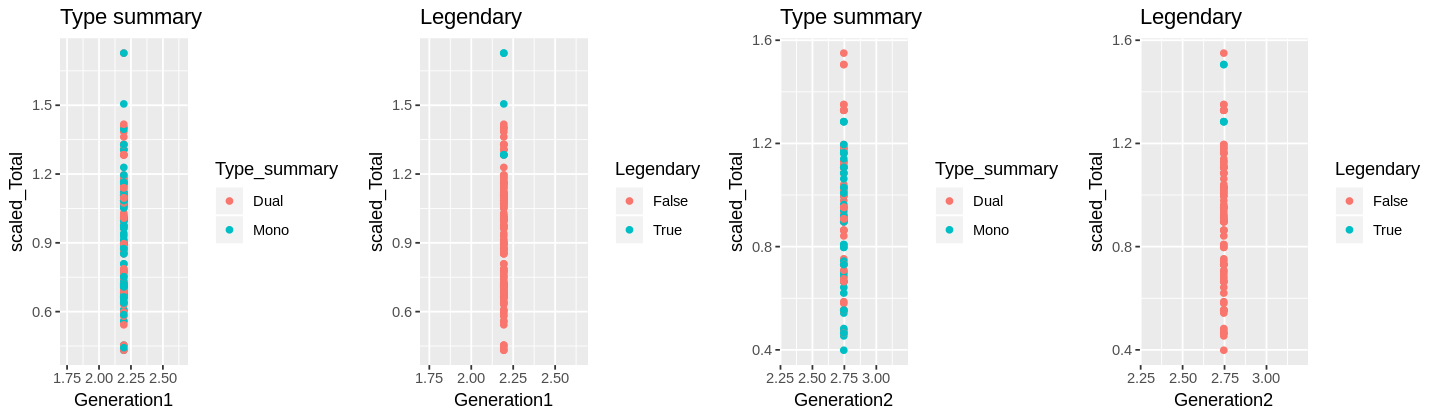

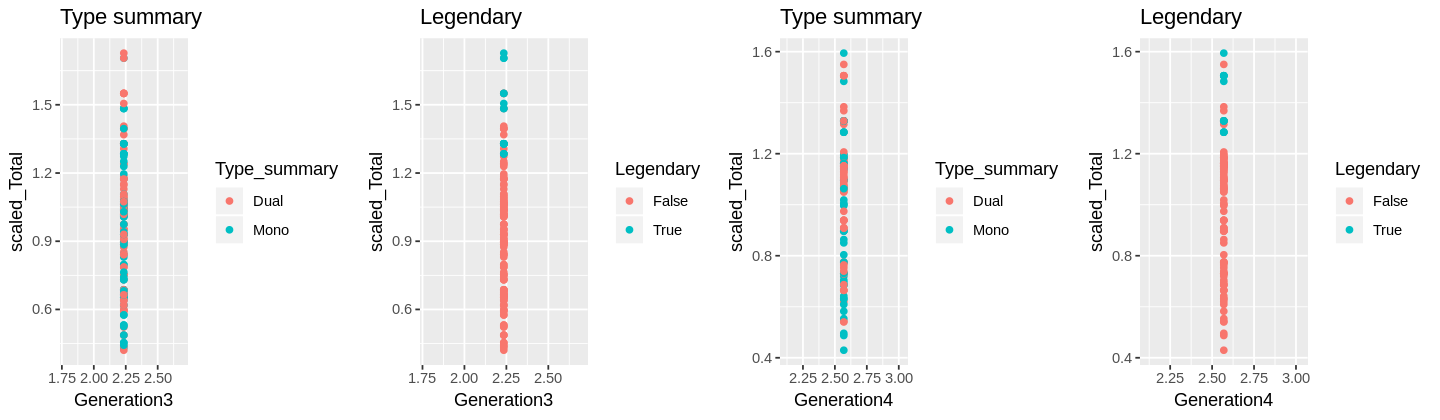

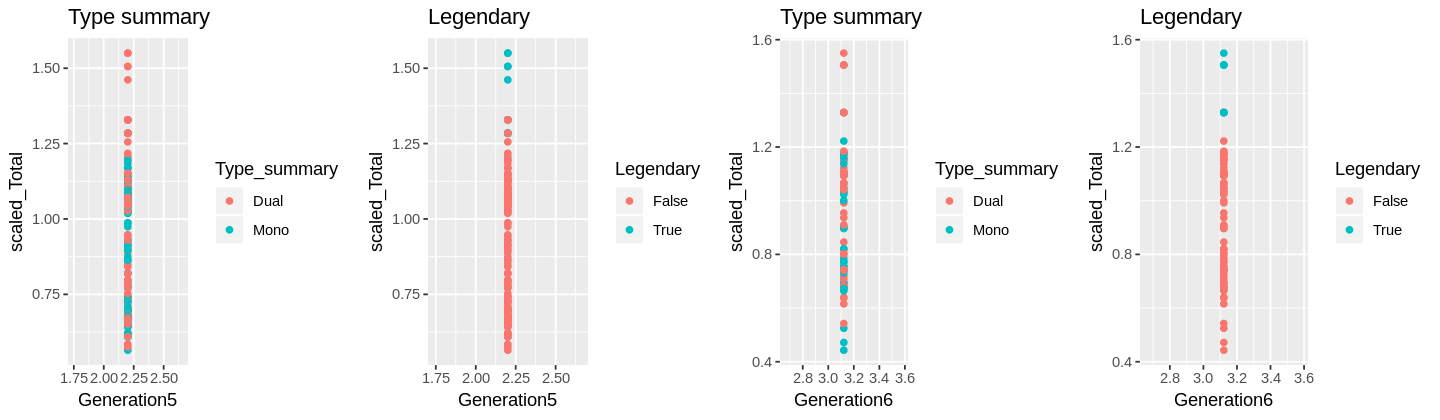

In [85]:
options(repr.plot.width= 12, repr.plot.height= 3.5)

viz4 <- scaled_pokemon %>% filter(!scaled_Gen_1 == 0)%>%
        ggplot(aes(x= scaled_Gen_1, y= scaled_Total, colour = Type_summary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation1")+
        ggtitle("Type summary")

viz5 <- scaled_pokemon %>% filter(!scaled_Gen_1 == 0)%>%
        ggplot(aes(x= scaled_Gen_1, y= scaled_Total, colour = Legendary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation1")+
        ggtitle("Legendary")

viz6 <- scaled_pokemon %>% filter(!scaled_Gen_2 == 0)%>%
        ggplot(aes(x= scaled_Gen_2, y= scaled_Total, colour = Type_summary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation2")+
        ggtitle("Type summary")

viz7 <- scaled_pokemon %>% filter(!scaled_Gen_2 == 0)%>%
        ggplot(aes(x= scaled_Gen_2, y= scaled_Total, colour = Legendary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation2")+
        ggtitle("Legendary")

grid.arrange(viz4, viz5, viz6, viz7, ncol = 4)

viz8 <- scaled_pokemon %>% filter(!scaled_Gen_3 == 0)%>%
        ggplot(aes(x= scaled_Gen_3, y= scaled_Total, colour = Type_summary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation3")+
        ggtitle("Type summary")

viz9 <- scaled_pokemon %>% filter(!scaled_Gen_3 == 0)%>%
        ggplot(aes(x= scaled_Gen_3, y= scaled_Total, colour = Legendary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation3")+
        ggtitle("Legendary")

viz10 <- scaled_pokemon %>% filter(!scaled_Gen_4 == 0)%>%
        ggplot(aes(x= scaled_Gen_4, y= scaled_Total, colour = Type_summary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation4")+
        ggtitle("Type summary")

viz11 <- scaled_pokemon %>% filter(!scaled_Gen_4 == 0)%>%
        ggplot(aes(x= scaled_Gen_4, y= scaled_Total, colour = Legendary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation4")+
        ggtitle("Legendary")

grid.arrange(viz8, viz9, viz10, viz11, ncol = 4)

viz12 <- scaled_pokemon %>% filter(!scaled_Gen_5 == 0)%>%
        ggplot(aes(x= scaled_Gen_5, y= scaled_Total, colour = Type_summary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation5")+
        ggtitle("Type summary")

viz13 <- scaled_pokemon %>% filter(!scaled_Gen_5 == 0)%>%
        ggplot(aes(x= scaled_Gen_5, y= scaled_Total, colour = Legendary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation5")+
        ggtitle("Legendary")

viz14 <- scaled_pokemon %>% filter(!scaled_Gen_6 == 0)%>%
        ggplot(aes(x= scaled_Gen_6, y= scaled_Total, colour = Type_summary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation6")+
        ggtitle("Type summary")

viz15 <- scaled_pokemon %>% filter(!scaled_Gen_6 == 0)%>%
        ggplot(aes(x= scaled_Gen_6, y= scaled_Total, colour = Legendary))+
        geom_point()+
        #geom_bar(stat = "identity")+
        labs(x= "Generation6")+
        ggtitle("Legendary")

grid.arrange(viz12, viz13, viz14, viz15, ncol = 4)

## Models

(write-up about what are the three models we are using, why we do so, and what we expect)

In [30]:
#knn using full data (model 1)
set.seed(151)
training_rows <- scaled_pokemon %>%
    select(Legendary) %>%
    unlist() %>%
    createDataPartition(p=0.80, list=FALSE)

scaled_pokemon <- scaled_pokemon %>%
    mutate(Legendary=as.factor(Legendary))

scaled_pokemon$Type_2[is.na(scaled_pokemon$Type_2)] <- 'Not_Dual'

X_train <- scaled_pokemon %>% 
    select(scaled_Total, scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, 
           scaled_Special_Defense, scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3,
           scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% 
    slice(training_rows) %>% 
    data.frame()

Y_train_legendary <- scaled_pokemon %>% 
    select(Legendary) %>% 
    slice(training_rows) %>% 
    unlist()

Y_train_type1 <- scaled_pokemon %>% 
    select(Type_1) %>% 
    slice(training_rows) %>% 
    unlist()

Y_train_type2 <- scaled_pokemon %>% 
    select(Type_2) %>% 
    slice(training_rows) %>% 
    unlist()

X_test <- scaled_pokemon %>% 
    select(scaled_Total, scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, 
           scaled_Special_Defense, scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3,
           scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% 
    slice(-training_rows) %>% 
    data.frame()

Y_test_legendary <- scaled_pokemon %>% 
    select(Legendary) %>% 
    slice(-training_rows) %>%
    unlist()

Y_test_type1 <- scaled_pokemon %>% 
    select(Type_1) %>% 
    slice(training_rows) %>% 
    unlist()

Y_test_type2 <- scaled_pokemon %>% 
    select(Type_2) %>% 
    slice(training_rows) %>% 
    unlist()

ks <- data.frame(k=c(1:11))
train_control <- trainControl(method='cv', number=10)

In [31]:
set.seed(151)
knn_cv_legendary <- train(x=X_train, y=Y_train_legendary, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_legendary

k-Nearest Neighbors 

640 samples
 13 predictor
  2 classes: 'False', 'True' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 576, 577, 576, 576, 576, 576, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9343487  0.5426931
   2  0.9344200  0.5106458
   3  0.9390346  0.5127300
   4  0.9374969  0.4811038
   5  0.9328335  0.4091742
   6  0.9359585  0.4178401
   7  0.9327846  0.3727026
   8  0.9312221  0.3576159
   9  0.9296837  0.3169050
  10  0.9359096  0.3616908
  11  0.9312462  0.3304880

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 3.

In [32]:
set.seed(151)
knn_cv_type1 <- train(x=X_train, y=Y_train_type1, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_type1

k-Nearest Neighbors 

640 samples
 13 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 579, 576, 575, 576, 578, 577, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.2003617  0.13394645
   2  0.1531383  0.08220157
   3  0.1593651  0.08532505
   4  0.1630684  0.08822271
   5  0.1638363  0.08529651
   6  0.1720942  0.09395249
   7  0.1534087  0.06984438
   8  0.1567841  0.07312510
   9  0.1644225  0.07985860
  10  0.1610713  0.07310562
  11  0.1506313  0.06157116

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

In [33]:
set.seed(151)
knn_cv_type2 <- train(x=X_train, y=Y_train_type2, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_type2

k-Nearest Neighbors 

640 samples
 13 predictor
 19 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Not_Dual', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 575, 576, 576, 575, 577, 577, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.3592586  0.10662712
   2  0.3262950  0.08354574
   3  0.3579155  0.06810994
   4  0.3937622  0.07730063
   5  0.4171058  0.08288832
   6  0.4404472  0.08455648
   7  0.4451362  0.07050778
   8  0.4529976  0.06065438
   9  0.4576873  0.06034738
  10  0.4625206  0.05509807
  11  0.4703812  0.04541751

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 11.

In [93]:
#knn using mono types data only to predict legendary status (model 2)

set.seed(1234)
training_rows <- scaled_pokemon %>% 
mutate(Legendary = as.factor(Legendary)) %>%
  select(Legendary) %>% 
  unlist() %>% 
  createDataPartition(p = 0.80, list = FALSE)

training_set <- scaled_pokemon %>% filter(Type_summary == "Mono") %>% slice(training_rows)
testing_set <- scaled_pokemon %>%  slice(-training_rows) %>% filter(Type_summary == "Mono")

head(training_set)
head(testing_set)

Type_1,Type_2,Legendary,Type_summary,scaled_Total,scaled_Hit_Points,scaled_Attack,scaled_Defense,scaled_Special_Attack,scaled_Special_Defense,scaled_Speed,scaled_Gen_1,scaled_Gen_2,scaled_Gen_3,scaled_Gen_4,scaled_Gen_5,scaled_Gen_6
Fire,NA,False,Mono,0.6842343,0.5280503,0.6085102,0.5361634,0.7511665,0.6481553,0.8754923,2.193913,0,0,0,0,0
Fire,NA,False,Mono,0.8968120,0.7853056,0.7489357,0.7231971,1.0015554,0.8426019,1.0775290,2.193913,0,0,0,0,0
Water,NA,False,Mono,1.3950409,1.0696404,1.2053183,1.4962698,1.6901247,1.4907572,1.0505908,2.193913,0,0,0,0,0
Bug,NA,False,Mono,0.4317984,0.6092888,0.3510636,0.4364120,0.2503888,0.2592621,0.6061101,2.193913,0,0,0,0,0
Bug,NA,False,Mono,0.4539419,0.6769876,0.2340424,0.6857903,0.3129861,0.3240777,0.4040734,2.193913,0,0,0,0,0
Normal,NA,False,Mono,0.5602307,0.4061925,0.6553187,0.4364120,0.3129861,0.4537087,0.9697761,2.193913,0,0,0,0,0


Type_1,Type_2,Legendary,Type_summary,scaled_Total,scaled_Hit_Points,scaled_Attack,scaled_Defense,scaled_Special_Attack,scaled_Special_Defense,scaled_Speed,scaled_Gen_1,scaled_Gen_2,scaled_Gen_3,scaled_Gen_4,scaled_Gen_5,scaled_Gen_6
Fire,NA,False,Mono,0.6842343,0.5280503,0.6085102,0.5361634,0.7511665,0.6481553,0.8754923,2.193913,0,0,0,0,0
Water,NA,False,Mono,0.8968120,0.7988453,0.7372335,0.9975132,0.8137637,1.0370485,0.7812085,2.193913,0,0,0,0,0
Normal,NA,False,Mono,0.9145268,0.7446863,0.9478717,0.7481349,0.6259721,0.9074175,1.3065039,2.193913,0,0,0,0,0
Ground,NA,False,Mono,0.9964578,1.0154814,1.1702120,1.3715807,0.5633749,0.7129709,0.8754923,2.193913,0,0,0,0,0
Poison,NA,False,Mono,0.8082380,0.9477826,0.7255314,0.8354173,0.6885693,0.7129709,0.7542703,2.193913,0,0,0,0,0
Fire,NA,False,Mono,1.1182471,0.9884019,0.8893611,0.9351686,1.0140748,1.2963107,1.3469113,2.193913,0,0,0,0,0


In [96]:
Y_status <- training_set %>% select(Legendary) %>% unlist()
X_attributes <- training_set %>% select(scaled_Hit_Points, scaled_Attack, scaled_Defense, 
                                        scaled_Special_Attack, scaled_Special_Defense, 
                                        scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3, 
                                        scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% data.frame()

k <- c(1,3,5,7,9,11)
ks <- data.frame(k)

train_control <- trainControl(method = "cv", number = 10)
choose_k <- train(x = X_attributes, y = Y_status, method = 'knn', tuneGrid = ks, trControl = train_control)
choose_k

k_accuracies <- choose_k$results
k_accuracies 

k-Nearest Neighbors 

303 samples
 12 predictor
  2 classes: 'False', 'True' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 272, 273, 273, 273, 273, 273, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.9506452  0.49754172
   3  0.9372043  0.21239650
   5  0.9340860  0.06511628
   7  0.9307527  0.00000000
   9  0.9307527  0.00000000
  11  0.9307527  0.00000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9506452,0.49754172,0.031794559,0.3708903
3,0.9372043,0.21239650,0.024693234,0.3656230
5,0.9340860,0.06511628,0.014985766,0.2059158
7,0.9307527,0.00000000,0.009713196,0.0000000
9,0.9307527,0.00000000,0.009713196,0.0000000
11,0.9307527,0.00000000,0.009713196,0.0000000


In [97]:
final_k = data.frame(k = 1)
final_classifier_legendary <- train(x = X_attributes, y = Y_status, method = "knn", tuneGrid = final_k)
final_classifier_legendary


X_test <- testing_set %>% 
    select(scaled_Hit_Points, scaled_Attack, scaled_Defense, 
        scaled_Special_Attack, scaled_Special_Defense, 
        scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3, 
        scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% 
        data.frame()

Y_test <- testing_set %>% 
    select(Legendary) %>% 
    unlist()
test_pred <- predict(final_classifier_legendary, X_test) 
head(test_pred)


k-Nearest Neighbors 

303 samples
 12 predictor
  2 classes: 'False', 'True' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 303, 303, 303, 303, 303, 303, ... 
Resampling results:

  Accuracy   Kappa    
  0.9457331  0.5218033

Tuning parameter 'k' was held constant at a value of 1

[1] False False False False False False
Levels: False True

In [98]:
#knn using mono types data only to predict Type_1 (model 2)
set.seed(5678)   
training_rows2 <- scaled_pokemon %>% 
mutate(Type_1 = as.factor(Type_1)) %>%
  select(Type_1) %>% 
  unlist() %>% 
  createDataPartition(p = 0.80, list = FALSE)

Y_type1 <- training_set %>% select(Type_1) %>% unlist()

k <- c(1,3,5,7,9,11)
ks <- data.frame(k)


train_control2 <- trainControl(method = "cv", number = 10)

choose_k <- train(x = X_attributes, y = Y_type1, method = 'knn', tuneGrid = ks, trControl = train_control2)
choose_k

k_accuracies2 <- choose_k$results
k_accuracies2 

k-Nearest Neighbors 

303 samples
 12 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 272, 272, 272, 274, 272, 275, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.1952632  0.11658043
   3  0.1715911  0.08900864
   5  0.1784714  0.08374717
   7  0.1615533  0.06684523
   9  0.1583515  0.05876767
  11  0.1617019  0.05531892

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.1952632,0.11658043,0.07473645,0.08538417
3,0.1715911,0.08900864,0.05816237,0.07304048
5,0.1784714,0.08374717,0.07742227,0.08681777
7,0.1615533,0.06684523,0.06486816,0.07581190
9,0.1583515,0.05876767,0.05147582,0.05425150
11,0.1617019,0.05531892,0.05785204,0.06810480


In [99]:

final_k = data.frame(k = 1)
final_classifier_type1 <- train(x = X_attributes, y = Y_type1, method = "knn", tuneGrid = final_k)
final_classifier_type1

test_pred <- predict(final_classifier_type1, X_test) 
head(test_pred)


Warning message:
“predictions failed for Resample10: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample14: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample16: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

k-Nearest Neighbors 

303 samples
 12 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 303, 303, 303, 303, 303, 303, ... 
Resampling results:

  Accuracy  Kappa    
  0.195173  0.1185508

Tuning parameter 'k' was held constant at a value of 1

[1] Fire   Dragon Normal Water  Poison Fire  
18 Levels: Bug Dark Dragon Electric Fairy Fighting Fire Flying Ghost ... Water

In [39]:
#knn using mono types data only to predict Type_2 (model 2)
set.seed(1435)   
training_rows3 <- scaled_pokemon %>% 
mutate(Type_2 = as.factor(Type_2)) %>%
  select(Type_2) %>% 
  unlist() %>% 
  createDataPartition(p = 0.80, list = FALSE)

Y_type2 <- training_set %>% select(Type_2) %>% unlist()

k <- c(1,3,5,7,9,11)
ks <- data.frame(k)


train_control3 <- trainControl(method = "cv", number = 10)

choose_k <- train(x = X_attributes, y = Y_type2, method = 'knn', tuneGrid = ks, trControl = train_control3)
choose_k

k_accuracies2 <- choose_k$results
k_accuracies2 

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

k-Nearest Neighbors 

303 samples
 12 predictor
  1 classes: 'Not_Dual' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 273, 273, 273, 273, 273, 273, ... 
Resampling results across tuning parameters:

  k   Accuracy  Kappa
   1  1         NaN  
   3  1         NaN  
   5  1         NaN  
   7  1         NaN  
   9  1         NaN  
  11  1         NaN  

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 11.

k,Accuracy,Kappa,AccuracySD,KappaSD
1,1,NaN,0,NA
3,1,NaN,0,NA
5,1,NaN,0,NA
7,1,NaN,0,NA
9,1,NaN,0,NA
11,1,NaN,0,NA


In [40]:
final_k = data.frame(k = 1)
final_classifier_type2 <- train(x = X_attributes, y = Y_type2, method = "knn", tuneGrid = final_k)
final_classifier_type2

test_pred <- predict(final_classifier_type2, X_test) 
head(test_pred)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

k-Nearest Neighbors 

303 samples
 12 predictor
  1 classes: 'Not_Dual' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 303, 303, 303, 303, 303, 303, ... 
Resampling results:

  Accuracy  Kappa
  1         NaN  

Tuning parameter 'k' was held constant at a value of 1

[1] Not_Dual Not_Dual Not_Dual Not_Dual Not_Dual Not_Dual
Levels: Not_Dual

From the mono-models we see that training the model on mono type pokemon makes it very accurate in predicting legendary status of mono-type pokemon(95%) and distinguishing between a type1 and type2 pokemon with an accuracy of 100% when predicting type2. But it has a very low accuracy(19%) when predicting the types of the type1 pokemon which suggests that the predictor/ x variables are too similar amongst mono type pokemon to distinguish between them accurately.

In [41]:
#knn using Dual type only predicting legendary status (model 2)
set.seed(1234)
training_rows_d <- scaled_pokemon %>% 
mutate(Legendary = as.factor(Legendary)) %>%
  select(Legendary) %>% 
  unlist() %>% 
  createDataPartition(p = 0.80, list = FALSE)

training_set_d <- scaled_pokemon %>% filter(Type_summary == "Dual") %>% slice(training_rows)
testing_set_d <- scaled_pokemon %>%  slice(-training_rows) %>% filter(Type_summary == "Dual")

head(training_set_d)
head(testing_set_d)

Type_1,Type_2,Legendary,Type_summary,scaled_Total,scaled_Hit_Points,scaled_Attack,scaled_Defense,scaled_Special_Attack,scaled_Special_Defense,scaled_Speed,scaled_Gen_1,scaled_Gen_2,scaled_Gen_3,scaled_Gen_4,scaled_Gen_5,scaled_Gen_6
Grass,Poison,False,Dual,0.7041635,0.6092888,0.5734039,0.6109768,0.8137637,0.8426019,0.6061101,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,0.8968120,0.8123851,0.7255314,0.7855417,1.0015554,1.0370485,0.8081468,2.193913,0,0,0,0,0
Fire,Dragon,False,Dual,1.4038983,1.0561006,1.5212756,1.3840496,1.6275275,1.1018641,1.3469113,2.193913,0,0,0,0,0
Fire,Flying,False,Dual,1.4038983,1.0561006,1.2170204,0.9725754,1.9905913,1.4907572,1.3469113,2.193913,0,0,0,0,0
Bug,Flying,False,Dual,0.8746685,0.8123851,0.5265954,0.6234458,1.1267498,1.0370485,0.9428379,2.193913,0,0,0,0,0
Bug,Poison,False,Dual,0.4317984,0.5415901,0.4095742,0.3740675,0.2503888,0.2592621,0.6734556,2.193913,0,0,0,0,0


Type_1,Type_2,Legendary,Type_summary,scaled_Total,scaled_Hit_Points,scaled_Attack,scaled_Defense,scaled_Special_Attack,scaled_Special_Defense,scaled_Speed,scaled_Gen_1,scaled_Gen_2,scaled_Gen_3,scaled_Gen_4,scaled_Gen_5,scaled_Gen_6
Grass,Poison,False,Dual,1.1625341,1.0831801,0.9595738,1.0349200,1.2519442,1.2963107,1.0775290,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,1.3839691,1.0831801,1.1702120,1.5336766,1.5273719,1.5555728,1.0775290,2.193913,0,0,0,0,0
Bug,Flying,False,Dual,0.8746685,0.8123851,0.5265954,0.6234458,1.1267498,1.0370485,0.9428379,2.193913,0,0,0,0,0
Normal,Flying,False,Dual,0.5558020,0.5415901,0.5265954,0.4987566,0.4381805,0.4537087,0.7542703,2.193913,0,0,0,0,0
Normal,Flying,False,Dual,0.7728084,0.8530043,0.7021272,0.6857903,0.6259721,0.6481553,0.9563070,2.193913,0,0,0,0,0
Normal,Flying,False,Dual,0.5801599,0.5415901,0.7021272,0.3740675,0.3881027,0.4018563,0.9428379,2.193913,0,0,0,0,0


In [42]:
Y_train_d <- training_set_d %>% select(Legendary) %>% unlist()
X_train_d <- training_set_d %>% select(scaled_Hit_Points, scaled_Attack, scaled_Defense, 
                                        scaled_Special_Attack, scaled_Special_Defense, 
                                        scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3, 
                                        scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% data.frame()

k <- c(1,3,5,7,9,11)
ks <- data.frame(k)

train_control <- trainControl(method = "cv", number = 10)
choose_k_d <- train(x = X_train_d, y = Y_train_d, method = 'knn', tuneGrid = ks, trControl = train_control)
choose_k_d

k_accuracies_d <- choose_k_d$results
k_accuracies_d

k-Nearest Neighbors 

327 samples
 12 predictor
  2 classes: 'False', 'True' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 294, 295, 295, 294, 294, 294, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9327652  0.6549248
   3  0.9266098  0.5966679
   5  0.9174242  0.4821773
   7  0.9206439  0.4731765
   9  0.9176136  0.4248699
  11  0.9116477  0.3427271

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9327652,0.6549248,0.03784984,0.1748296
3,0.9266098,0.5966679,0.04564977,0.2219542
5,0.9174242,0.4821773,0.03216539,0.2402466
7,0.9206439,0.4731765,0.03804100,0.2464767
9,0.9176136,0.4248699,0.03775759,0.2515747
11,0.9116477,0.3427271,0.03580177,0.2375988


In [43]:
#test on k = 3
Y_train_d2 <- training_set %>% select(Legendary) %>% unlist()
X_train_d2 <- training_set %>% select(scaled_Hit_Points, scaled_Attack, scaled_Defense, 
                                        scaled_Special_Attack, scaled_Special_Defense, 
                                        scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3, 
                                        scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% data.frame()


final_kd = data.frame(k = 3)
final_classifier_legendary_d <- train(x = X_train_d2, y = Y_train_d2, method = "knn", tuneGrid = final_kd)
final_classifier_legendary_d


X_test_d2 <- testing_set_d %>% 
    select(scaled_Hit_Points, scaled_Attack, scaled_Defense, 
        scaled_Special_Attack, scaled_Special_Defense, 
        scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3, 
        scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% 
        data.frame()

Y_test_d2 <- testing_set_d %>% 
    select(Legendary) %>% 
    unlist()
test_pred_d <- predict(final_classifier_legendary_d, X_test_d2) 
head(test_pred_d)

k-Nearest Neighbors 

303 samples
 12 predictor
  2 classes: 'False', 'True' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 303, 303, 303, 303, 303, 303, ... 
Resampling results:

  Accuracy   Kappa    
  0.9371793  0.3776984

Tuning parameter 'k' was held constant at a value of 3

[1] False False False False False False
Levels: False True

In [44]:
#knn using dual types data only to predict Type_1 (model 2)
set.seed(5678)   
training_rows2_d <- scaled_pokemon %>% 
mutate(Type_1 = as.factor(Type_1)) %>%
  select(Type_1) %>% 
  unlist() %>% 
  createDataPartition(p = 0.80, list = FALSE)

Y_type1_d <- training_set_d %>% select(Type_1) %>% unlist()

k <- c(1,3,5,7,9,11)
kks <- data.frame(k)


train_control2_d <- trainControl(method = "cv", number = 10)

choose_k_d3 <- train(x = X_train_d, y = Y_type1_d, method = 'knn', tuneGrid = kks, trControl = train_control2_d)
choose_k_d3

k_accuracies2_d <- choose_k_d3$results
k_accuracies2_d

Warning message:
“predictions failed for Fold10: k= 1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Fold10: k= 3 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Fold10: k= 5 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Fold10: k= 7 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Fold10: k= 9 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Fold10: k=11 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

k-Nearest Neighbors 

327 samples
 12 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 298, 293, 296, 297, 293, 295, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.2458138  0.18281744
   3  0.1875831  0.11944745
   5  0.1717389  0.09992249
   7  0.1870474  0.11272043
   9  0.1867106  0.10963513
  11  0.1746942  0.09396675

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.2458138,0.18281744,0.10023991,0.10941390
3,0.1875831,0.11944745,0.06156023,0.06247315
5,0.1717389,0.09992249,0.06342728,0.07071898
7,0.1870474,0.11272043,0.06609838,0.07436145
9,0.1867106,0.10963513,0.07057343,0.07574137
11,0.1746942,0.09396675,0.06500294,0.07408662


In [45]:
final_k = data.frame(k = 1)
final_classifier_type1_d <- train(x = X_train_d, y = Y_type1_d, method = "knn", tuneGrid = final_k)
final_classifier_type1_d

test_pred_d <- predict(final_classifier_type1_d, X_test_d2) 
head(test_pred_d)

Warning message:
“predictions failed for Resample01: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample02: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample06: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample07: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample08: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample09: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample11: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning messa

k-Nearest Neighbors 

327 samples
 12 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 327, 327, 327, 327, 327, 327, ... 
Resampling results:

  Accuracy   Kappa    
  0.2040254  0.1416021

Tuning parameter 'k' was held constant at a value of 1

[1] Poison Fire   Bug    Normal Normal Normal
18 Levels: Bug Dark Dragon Electric Fairy Fighting Fire Flying Ghost ... Water

In [46]:
#knn using Dual types data only to predict Type_2 (model 2)
set.seed(1435)   
training_rows3_d <- scaled_pokemon %>% 
mutate(Type_2 = as.factor(Type_2)) %>%
  select(Type_2) %>% 
  unlist() %>% 
  createDataPartition(p = 0.80, list = FALSE)

Y_type2_d <- training_set_d %>% select(Type_2) %>% unlist()

k <- c(1,3,5,7,9,11)
ks <- data.frame(k)


train_control3_d <- trainControl(method = "cv", number = 10)

choose_k_d <- train(x = X_train_d, y = Y_type2_d, method = 'knn', tuneGrid = ks, trControl = train_control3_d)
choose_k_d

k_accuracies2_d <- choose_k_d$results
k_accuracies2_d

k-Nearest Neighbors 

327 samples
 12 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 296, 294, 296, 294, 293, 293, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.2995429  0.2118374
   3  0.2714876  0.1786466
   5  0.2645625  0.1619522
   7  0.2850497  0.1712489
   9  0.2840003  0.1695245
  11  0.2966423  0.1808772

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.2995429,0.2118374,0.07758183,0.08776478
3,0.2714876,0.1786466,0.08590694,0.09323327
5,0.2645625,0.1619522,0.10186800,0.11591703
7,0.2850497,0.1712489,0.08545017,0.09665607
9,0.2840003,0.1695245,0.09262634,0.10480822
11,0.2966423,0.1808772,0.09079941,0.10373043


In [47]:
final_k_d = data.frame(k = 1)
final_classifier_type2_d <- train(x = X_train_d, y = Y_type2_d, method = "knn", tuneGrid = final_k_d)
final_classifier_type2_d

test_pred_d <- predict(final_classifier_type2_d, X_test_d2) 
head(test_pred_d)

Warning message:
“predictions failed for Resample05: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample19: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample21: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

k-Nearest Neighbors 

327 samples
 12 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 327, 327, 327, 327, 327, 327, ... 
Resampling results:

  Accuracy   Kappa    
  0.2768639  0.1923828

Tuning parameter 'k' was held constant at a value of 1

[1] Ground Flying Flying Flying Flying Flying
18 Levels: Bug Dark Dragon Electric Fairy Fighting Fire Flying Ghost ... Water

## Discussion 

The accuracy of our models in predicting the pokemon types is lower than we expected. We assumed that in using all of the attributes given we would get a better predicting model for all the pokemon Types and Legendary status. But from the results above, it is clear that the predictions for the Legendary status for each model was much higher compared to that of the Type predictions which was very low. So in an effort to increase the accuracy of the Type predictions we split the data into Mono and Dual data sets and created classification models to see if that would increase the accuracy of the like Type prediction (i.e Mono = better prediction for Type_1 and Dual = better prediction for Type_2). But as this approach failed as well, we suspect that the variables used are just too similar among the pokemon that they fail to accurately distinguish between Type_1 and Type_2 pokemon.

So just to see if we could increase the accuracy of our models in predicting Types, we decided to use a subset of the x-variables based on those that differentiate between the mono and dual types best(i.e those that have a significant difference in the means). This process is shown below.

In [48]:
#trying to see if we can use a subset of the x-variables based on those that differentiate between 
#the mono and dual types best.(i.e those that have a significant difference in the means)
#All in an effort to see if we could have increased the accuracy of the prediction models
means <- scaled_pokemon %>% 
        group_by(Type_summary) %>%
        summarise(average_Hit_Points = mean(scaled_Hit_Points, trim = 0,na.rm = TRUE),
                average_attack = mean(scaled_Attack,trim = 0,na.rm = TRUE),
                average_defense = mean(scaled_Defense,trim = 0,na.rm = TRUE),
                average_SPattack = mean(scaled_Special_Attack,trim = 0,na.rm = TRUE),
                average_SPdefense = mean(scaled_Special_Defense,trim = 0,na.rm = TRUE),
                average_speed = mean(scaled_Speed,trim = 0,na.rm = TRUE),
                average_Gen1 = mean(scaled_Gen_1,trim = 0,na.rm = TRUE),
                average_Gen2 = mean(scaled_Gen_2,trim = 0,na.rm = TRUE),
                average_Gen3 = mean(scaled_Gen_3,trim = 0,na.rm = TRUE),
                average_Gen4 = mean(scaled_Gen_4,trim = 0,na.rm = TRUE),
                average_Gen5 = mean(scaled_Gen_5,trim = 0,na.rm = TRUE),
                average_Gen6 = mean(scaled_Gen_6,trim = 0,na.rm = TRUE))
        
means
#Gen2 and Gen3 seem to have the smallest difference in means but removing them only would make the model inaccurate because
#we would still be including the other generations' data. To combat this we would have to remove all generation column data...
#so lets try that.

Type_summary,average_Hit_Points,average_attack,average_defense,average_SPattack,average_SPdefense,average_speed,average_Gen1,average_Gen2,average_Gen3,average_Gen4,average_Gen5,average_Gen6
Dual,0.9565802,0.9733111,0.9934774,0.9646018,0.9795600,0.9497676,0.4133459,0.3647395,0.4426158,0.4158677,0.4358579,0.3769955
Mono,0.9175462,0.8721111,0.8427178,0.8548898,0.8811554,0.8873214,0.5001666,0.3627466,0.4515654,0.3594903,0.4731755,0.2587791


In [103]:
#knn using mono types data only to predict Type_1 *** without Generation columns
set.seed(5678)   
training_rows2 <- scaled_pokemon %>% 
mutate(Type_1 = as.factor(Type_1)) %>%
  select(Type_1) %>% 
  unlist() %>% 
  createDataPartition(p = 0.80, list = FALSE)

X_train1 <- training_set %>% select(scaled_Hit_Points, scaled_Attack, scaled_Defense, 
                                        scaled_Special_Attack, scaled_Special_Defense, 
                                        scaled_Speed) %>% data.frame()
Y_type1 <- training_set %>% select(Type_1) %>% unlist()

k <- c(1,3,5,7,9,11,13,15)
ks <- data.frame(k)


train_control2 <- trainControl(method = "cv", number = 10)

choose_k <- train(x = X_train1, y = Y_type1, method = 'knn', tuneGrid = ks, trControl = train_control2)
choose_k

k_accuracies2 <- choose_k$results
k_accuracies2 

k-Nearest Neighbors 

303 samples
  6 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 272, 272, 272, 274, 272, 275, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.2388253  0.1647815
   3  0.2196721  0.1446672
   5  0.2150623  0.1332506
   7  0.2686736  0.1852110
   9  0.2854740  0.1969624
  11  0.2950567  0.2057363
  13  0.2881825  0.2002442
  15  0.2738514  0.1841222

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 11.

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.2388253,0.1647815,0.08323772,0.08965695
3,0.2196721,0.1446672,0.06535066,0.07102904
5,0.2150623,0.1332506,0.04838330,0.05320029
7,0.2686736,0.1852110,0.07161798,0.07932817
9,0.2854740,0.1969624,0.06491989,0.06881775
11,0.2950567,0.2057363,0.06380790,0.06889816
13,0.2881825,0.2002442,0.07386070,0.08545752
15,0.2738514,0.1841222,0.10196832,0.11452781


From the model above we can see that the accuracy of prediction for Type_1 pokemon using the Mono data has increased compared to what it was when Generation data was included(from 0.1952632 to 0.2950567). This shows that the Generation columns were probably noise variables that did little in terms of differentiating between Mono and Dual types.

## Conclusion